Import Of Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)
from sklearn.inspection import permutation_importance

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


Loading Of Datasets

In [4]:
from google.colab import files
uploaded = files.upload()

for name in uploaded.keys():
    print("Uploaded:", name)
    dataset_path = name  # Use the uploaded filename

df = pd.read_csv(dataset_path)
df.head()

Saving sowutuom_clinic_dataset.csv to sowutuom_clinic_dataset.csv
Uploaded: sowutuom_clinic_dataset.csv


,clinic,age,height,weight,bmi,glucose_level,blood_group,genotype,diabetic
0,clinic_7,69,197.36,45.82,11.76,155,B-,SS,0
1,clinic_4,32,199.30,55.27,13.91,103,A+,SS,0
2,clinic_3,89,187.67,112.50,31.94,124,A-,AA,0
3,clinic_1,78,168.81,110.54,38.79,188,A+,SS,1
4,clinic_8,38,154.18,89.81,37.78,183,A-,AA,1


Inspection Of Dataset

In [5]:
print(df.shape)
print(df.info())
df.describe(include="all")


(500, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   clinic         500 non-null    object 
 1   age            500 non-null    int64  
 2   height         500 non-null    float64
 3   weight         500 non-null    float64
 4   bmi            500 non-null    float64
 5   glucose_level  500 non-null    int64  
 6   blood_group    500 non-null    object 
 7   genotype       500 non-null    object 
 8   diabetic       500 non-null    int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 35.3+ KB
None


,clinic,age,height,weight,bmi,glucose_level,blood_group,genotype,diabetic
count,500,500.000000,500.000000,500.000000,500.000000,500.000000,500,500,500.000000
unique,10,NaN,NaN,NaN,NaN,NaN,8,3,NaN
top,clinic_6,NaN,NaN,NaN,NaN,NaN,A+,SS,NaN
freq,57,NaN,NaN,NaN,NaN,NaN,77,173,NaN
mean,NaN,53.202000,174.470720,83.174920,27.954800,134.024000,NaN,NaN,0.498000
std,NaN,21.158179,14.558554,22.374092,9.102117,38.876963,NaN,NaN,0.500497
min,NaN,18.000000,150.230000,45.370000,11.760000,70.000000,NaN,NaN,0.000000
25%,NaN,34.750000,161.452500,62.655000,20.572500,99.750000,NaN,NaN,0.000000
50%,NaN,52.000000,174.145000,83.875000,27.390000,134.000000,NaN,NaN,0.000000
75%,NaN,72.000000,187.277500,102.660000,34.497500,169.250000,NaN,NaN,1.000000


Check missing values & class distribution

In [6]:
print("Missing values:")
print(df.isnull().sum())

print("\nDiabetic distribution:")
print(df["diabetic"].value_counts())
print(df["diabetic"].value_counts(normalize=True))


Missing values:
clinic           0
age              0
height           0
weight           0
bmi              0
glucose_level    0
blood_group      0
genotype         0
diabetic         0
dtype: int64

Diabetic distribution:
diabetic
0    251
1    249
Name: count, dtype: int64
diabetic
0    0.502
1    0.498
Name: proportion, dtype: float64


Prepare feature lists

In [7]:
categorical_cols = ["clinic", "blood_group", "genotype"]
numeric_cols = ["age", "height", "weight", "bmi", "glucose_level"]

X = df.drop(columns=["diabetic"])
y = df["diabetic"]

X.head()


,clinic,age,height,weight,bmi,glucose_level,blood_group,genotype
0,clinic_7,69,197.36,45.82,11.76,155,B-,SS
1,clinic_4,32,199.30,55.27,13.91,103,A+,SS
2,clinic_3,89,187.67,112.50,31.94,124,A-,AA
3,clinic_1,78,168.81,110.54,38.79,188,A+,SS
4,clinic_8,38,154.18,89.81,37.78,183,A-,AA


Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((400, 8), (100, 8))

((400, 8), (100, 8))

Preprocessing Pipeline

In [12]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

Build Model Pipelines

In [13]:
log_pipe = Pipeline(steps=[
    ("preproc", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

rf_pipe = Pipeline(steps=[
    ("preproc", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])


Train Models

In [14]:
log_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

print("Models trained!")


Models trained!


Predictions & Evaluation Function

In [15]:
def evaluate(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f"\n=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Evaluate Logistic Regression & Random Forest

In [16]:
evaluate(log_pipe, X_test, y_test, "Logistic Regression")
evaluate(rf_pipe, X_test, y_test, "Random Forest")



=== Logistic Regression ===
Accuracy: 0.62
Precision: 0.62
Recall: 0.62
F1 Score: 0.62
ROC AUC: 0.6619999999999999

Confusion Matrix:
[[31 19]
 [19 31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        50
           1       0.62      0.62      0.62        50

    accuracy                           0.62       100
   macro avg       0.62      0.62      0.62       100
weighted avg       0.62      0.62      0.62       100


=== Random Forest ===
Accuracy: 0.6
Precision: 0.6041666666666666
Recall: 0.58
F1 Score: 0.5918367346938775
ROC AUC: 0.6512

Confusion Matrix:
[[31 19]
 [21 29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61        50
           1       0.60      0.58      0.59        50

    accuracy                           0.60       100
   macro avg       0.60      0.60      0.60       100
weighted avg       0.60      0.60   

ROC Curve Plot

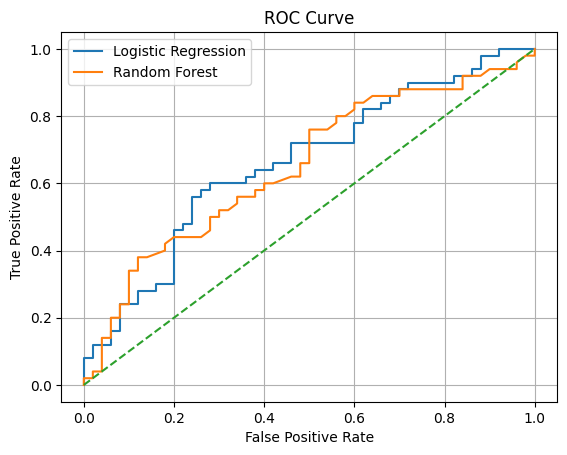

In [17]:
plt.figure()
# LR
lr_prob = log_pipe.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")

# RF
rf_prob = rf_pipe.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
plt.plot(fpr_rf, tpr_rf, label="Random Forest")

plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


Feature Importance (Logistic Regression Coefficients)

In [18]:
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
ohe_features = ohe.get_feature_names_out(categorical_cols)
feature_names = numeric_cols + list(ohe_features)

log_coeff = log_pipe.named_steps["clf"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": log_coeff
}).sort_values("coef", ascending=False)

coef_df.head(15)


,feature,coef
2,weight,1.283915
4,glucose_level,0.899915
6,clinic_clinic_10,0.569200
15,blood_group_A+,0.490638
20,blood_group_B-,0.390285
9,clinic_clinic_4,0.268173
23,genotype_AA,0.250851
12,clinic_clinic_7,0.194355
13,clinic_clinic_8,0.181738
14,clinic_clinic_9,0.079971


Feature Importance (Random Forest)

In [19]:
rf_importances = rf_pipe.named_steps["clf"].feature_importances_

rf_df = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

rf_df.head(15)


,feature,importance
4,glucose_level,0.193007
3,bmi,0.168296
2,weight,0.144621
1,height,0.143128
0,age,0.097532
23,genotype_AA,0.019650
25,genotype_SS,0.015919
8,clinic_clinic_3,0.014491
20,blood_group_B-,0.014415
15,blood_group_A+,0.014276


Permutation Importance

In [21]:
perm = permutation_importance(
    rf_pipe, X_test, y_test, n_repeats=15,
    random_state=RANDOM_STATE
)

perm_df = pd.DataFrame({
    "feature": X_test.columns, # Use original feature names
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

perm_df.head(10)

,feature,importance_mean,importance_std
5,glucose_level,0.057333,0.041708
1,age,0.010667,0.007717
4,bmi,0.005333,0.027777
0,clinic,0.004000,0.016653
3,weight,-0.009333,0.018427
6,blood_group,-0.014667,0.015434
7,genotype,-0.023333,0.011926
2,height,-0.040000,0.024766


Save Trained Models

In [22]:
joblib.dump(log_pipe, "logistic_diabetes_model.joblib")
joblib.dump(rf_pipe, "random_forest_diabetes_model.joblib")

print("Models saved!")


Models saved!
